In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
%matplotlib inline

is_cuda = False
if torch. cuda.is_available():                          #gpu를 사용할 수 있는지 확인하고 사용할 수 있으면 is_cuda라는 변수에 true값을 준다.
  is_cuda = True

transformation = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,),(0.3081,))]) #이미지를 텐서로 변환, #정규화 시키는 것 보통 0.5 0.5 표준, 표준편차를 체널별로 준다.

train_dataset = datasets.MNIST('data/', train = True, transform = transformation, download = True) #train, test dataset을 다운로드 하는 것.
test_dataset = datasets.MNIST('data/', train = False, transform = transformation, download = True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle = True) #파라미터 : 데이터 값, 배치 사이즈, 랜덤 여부
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 32, shuffle = True)

sample_data = next(iter(train_loader)) #batch 단위로 가지고 온다.

def plot_img(image):  #이미지를 출력해주는 함수.
  image = image.numpy()[0]
  mean = 0.1307
  std = 0.3081
  image = ((mean*image)+std)
  plt.imshow(image, cmap = 'gray')

0it [00:00, ?it/s]

9920512it [00:02, 3592226.80it/s]                             


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 58437.04it/s]                           
0it [00:00, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


1654784it [00:01, 958339.33it/s]                            
0it [00:00, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


8192it [00:00, 21752.62it/s]            

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


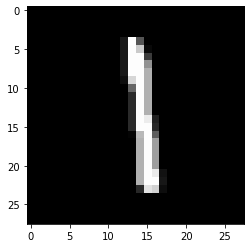

In [ ]:
plot_img(sample_data[0][2])

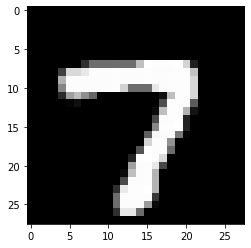

In [ ]:
plot_img(sample_data[0][1])

In [ ]:
class Net(nn.Module): #nn.Module을 항상 상속 받아서 사용
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 10, kernel_size = 5)  #1채널 -> 10채널, 필터의 크기 5, 스트라이드는 기본값으로 1, 그래서 24*24에 채널이 10개로 바뀐다.
                                                    #28 * 28 -> (28 - 5)/1 + 1 = 24
                                                    #24 * 24로 변환

    self.conv2 = nn.Conv2d(10, 20, kernel_size = 5) #10채널 -> 20채널, 필터의 크기 5, 스트라이드는 기본값으로 1, 그래서 24*24에 채널이 20개
                                                    #24 * 24 -> (24 - 5)/1 + 1 = 20
                                                    #20 *20으로 변환
                                                    #이 크기는 conv1을 돌리고 바로 했다는 가정으로 forward에서 사용한 거는 크기가 또 달라집니다. (아래에서 기술)

    self.conv2_drop = nn.Dropout2d()                #OverFitting을 방지하기 위해서 학습에서의 Fully Connect에서 몇개의 연결을 랜덤으로 없앤다.
    self.fc1 = nn.Linear(320, 50)                   #인풋이 320인 것인 Fully Connect의 아웃풋을 50인 벡터로 연산한다.
    self.fc2 = nn.Linear(50, 10)                    #인풋이 50인 것인 Fully Connect의 아웃풋을 10인 벡터로 연산한다.

  def forward(self, x):
    x = F.relu(F.max_pool2d(self.conv1(x),2))                       #conv1 (1채널 -> 10채널, 필터 크기 5, 스트라이드 1으로 연산하고) max_pool2d를 사용해서 가로세로를 반으로 바꾼다.
                                                                    #결과 크기 : 12 * 12 * 10 (가로, 세로, 크기)
    x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)),2))      #conv2 (10채널 -> 20채널, 필터 크기 5, 스트라이드 1으로 연산하고) max_pool2d를 사용해서 가로세로를 반으로 바꾼다.
                                                                    #conv2의 결과 크기 : (12 - 5)/1 + 1 = 8, 8 * 8 * 20, Maxpool을 하면서 4가 되어
                                                                    #결과크기는 4 * 4 * 20이 된다.
    x = x.view(-1, 320)                                             #텐서를 벡터로 변환
    x = F.relu(self.fc1(x))                                         #fc1을 연산하고 렐루를 통과시킨다.
                                                                    #결과 크기 : 320 -> 50인 벡터
    #x = F.dropout(x, p = 0.1, training = self.training)            #오버피팅을 방지하는 것이지만 주석처리가 되어있다. 주석처리 한 이유는 conv2_drop이 있기 때문이라고 추측한다.
    x = self.fc2(x)                                                 #fc2를 연산한다.
                                                                    #결과 크기 : 50 -> 10인 벡터
    return F.log_softmax(x, dim = 1)                 #log_softmax를 사용해서 확률 값으로 리턴한다.

model = Net()   #인스턴스 생성
if is_cuda:
  model.cuda()  #gpu사용

optimizer = optim.SGD(model.parameters(), lr = 0.01)          #Stochastic Gradient Descent이하 SGD를 옵티마이저로 사용

data , target = next(iter(train_loader))            #훈련 집합에서 다음 data랑 target을 뽑아서 변수로 저장한다.

output = model(Variable(data.cuda()))               #GPU에 인풋 데이터를 올린다.


NameError: ignored

In [ ]:
print(output.size())

torch.Size([32, 10])


In [ ]:
print(target.size())

torch.Size([32])


In [ ]:
def fit(epoch, model, data_loader, phase = 'training', volatile = False):
  if phase == 'training':   #훈련 시킬 때
    model.train()
  if phase == 'validation': #검증할 때
    model.eval()
    volatile = True
  running_loss = 0.0  #초기 러닝 레이트
  running_correct = 0
  for batch_idx, (data,target) in enumerate(data_loader):
    if is_cuda:
      data, target = data.cuda(), target.cuda()               #GPU에 올림.
    data, target = Variable(data, volatile), Variable(target) #data는 training이면 Variable(data, false)이면 역전파를 사용하기 위해서 메모리 상에 올리는 것이고,
                                                              #target은 volatile의 기본값이 true이기 때문에 메모리에 올리지 않는다(역전파를 하지 않을 것이기 때문에)
    if phase == 'training':
      optimizer.zero_grad()   #학습 시킬 경우.
    output = model(data)      #init과 포워드를 돌게 되어 output이 나온다.
    loss = F.nll_loss(output, target) #Negative log likelihood loss를 손실함수로 사용한다.

    running_loss += F.nll_loss(output,target, size_average=False).data    #batch마다 loss를 중첩해가는 과정
    preds = output.data.max(dim = 1, keepdim = True)[1]                   #예측값
    running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()   #실제값과의 유사도를 batch마다 중첩해가는 과정
    if phase == 'training':
      loss.backward()         #훈련에서의 역연산
      optimizer.step()        #가중치 갱신
  
  loss = running_loss/len(data_loader.dataset)  #로스의 평균
  accuracy = 100. * running_correct/len(data_loader.dataset)  #정확도(유사도의 평균을 100으로 곱해서 %로 변환)

  print(f'{phase} loss is {loss : {5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}') #출력
  return loss, accuracy

train_losses, train_accuracy = [], []
val_losses, val_accuracy = [], []
for epoch in range(1,20): #20번 학습시킨다.
  epoch_loss, epoch_accuracy = fit(epoch, model, train_loader, phase = 'training')  #위에 정의해준 fit를 사용해서 학습시킨다.
  val_epoch_loss, val_epoch_accuracy = fit(epoch, model, test_loader, phase = 'validation') #이것은 검증 하는 것이다.
  train_losses.append(epoch_loss) #각 에포크 마다 훈련의 loss를 배열에 추가해준다.
  train_accuracy.append(epoch_accuracy) #각 에포크 마다 훈련의 정확도를 배열에 추가해준다.
  val_losses.append(val_epoch_loss) #각 에포크 마다 검증의 loss를 배열에 추가해준다.
  val_accuracy.append(val_epoch_accuracy) #각 에포크 마다 검증의 정확도를 배열에 추가해준다.

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


training loss is  0.62 and training accuracy is 48414/60000     80.69
validation loss is  0.17 and validation accuracy is 9479/10000     94.79
training loss is   0.2 and training accuracy is 56454/60000     94.09
validation loss is   0.1 and validation accuracy is 9680/10000      96.8
training loss is  0.15 and training accuracy is 57310/60000     95.52
validation loss is  0.075 and validation accuracy is 9762/10000     97.62
training loss is  0.13 and training accuracy is 57784/60000     96.31
validation loss is  0.07 and validation accuracy is 9779/10000     97.79
training loss is  0.11 and training accuracy is 58026/60000     96.71
validation loss is  0.051 and validation accuracy is 9835/10000     98.35
training loss is   0.1 and training accuracy is 58208/60000     97.01
validation loss is  0.05 and validation accuracy is 9841/10000     98.41
training loss is  0.091 and training accuracy is 58380/60000      97.3
validation loss is  0.04 and validation accuracy is 9871/10000     98

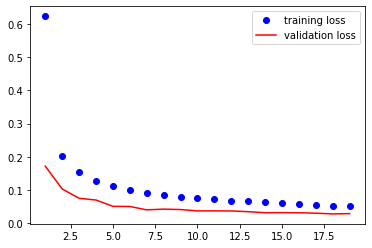

In [ ]:
plt.plot(range(1, len(train_losses)+1), train_losses, 'bo', label = 'training loss')  #에포크를 진행하면서 훈련의 loss의 변화를 출력한다.
plt.plot(range(1, len(val_losses)+1), val_losses, 'r', label = 'validation loss')     #에포크를 진행하면서 검증의 loss의 변화를 출력한다.
plt.legend()

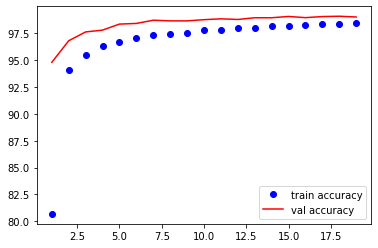

In [ ]:
plt.plot(range(1, len(train_accuracy)+1), train_accuracy, 'bo', label = 'train accuracy') #에포크의 진행에 따라 훈련의 정확도 변화를 출력한다.
plt.plot(range(1, len(val_accuracy)+1), val_accuracy, 'r', label = 'val accuracy')        #에포크의 진행에 따라 검증의 정확도 변화를 출력한다.
plt.legend()

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 6, 5)                           #인풋  채널 : 1, 아웃풋 채널 : 6, 커널 사이즈 : 5
    self.conv2 = nn.Conv2d(6, 16, 5)                          #인풋  채널 : 6, 아웃풋 채널 : 16, 커널 사이즈 : 5
    self.fc1 = nn.Linear(16 * 5 * 5, 120)                     #인풋 (벡터)사이즈 : 16*5*5, 아웃풋 (벡터)사이즈 : 120
    self.fc2 = nn.Linear(120, 84)                             #인풋 (벡터)사이즈 : 120, 아웃풋 (벡터)사이즈 : 84
    self.fc3 = nn.Linear(84,10)                               #인풋 (벡터)사이즈 : 84, 아웃풋 (벡터)사이즈 : 10
  def forward(self, x):
    x = F.max_pool2d(F.relu(self.conv1(x)),(2,2))             #conv1을 실행후 렐루 통과, max_pool2d(2,2)를 사용
                                                              #conv1, 렐루 통과 후 사이즈 : (32 - 5)/1 + 1 = 28 , 28 * 28 * 6
                                                              #max_pool2d(2,2) 통과 후 사이즈 : 28/2 = 14 , 14 * 14 * 6
    x = F.max_pool2d(F.relu(self.conv2(x)),2)                 #conv2를 실행후 렐루 통과, max_pool2d를 사용
                                                              #conv2, 렐루 통과 후 사이즈 : (14 - 5)/1 + 1 = 10, 10 * 10 * 16
                                                              #max_pool2d 통과 후 사이즈 : 5 * 5 * 16
    x = x.view(-1, self.num_flat_features(x))                 #num_flat_features은 x의 크기를 반환해주는 것으로, x.view(-1, 크기)이므로 텐서를 벡터로 변환해 주는 것이다.
    x = F.relu(self.fc1(x))                                   #Fully Connect 연산을 하는 것이다.(입력 크기 : 16 * 5 * 5, 아웃풋 크기 : 120)
    x = F.relu(self.fc2(x))                                   #Fully Connect 연산을 하는 것이다.(입력 크기 : 120, 아웃풋 크기 : 84)
    x = self.fc3(x)                                           #Fully Connect 연산을 하는 것이다.(입력 크기 : 84, 아웃풋 크기 : 10)
    return x
  def num_flat_features(self, x):                             #텐서의 크기를 반환해주는 함수
    size = x.size()[1:]
    num_features = 1
    for s in size:
      num_features *= s
    return num_features

net  = Net()                                                  #객체 생성
print(net)                                                    #객체 안에 있는 파라미터들을 호출해준다.

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [ ]:
params = list(net.parameters())             #parameters()를 하면 모든 파라미터가 들어감.
print(len(params))                          #레이어 층을 출력하는 것으로 추측한다.
print(params[0].size())                     #conv1의 파라미터 수를 출력한다.(아웃풋, 인풋, 커널 가로크기, 커널 세로크기로 추정)

10
torch.Size([6, 1, 5, 5])


In [ ]:
input = torch.randn(1,1,32,32)            #입력 영상을 만들어준다. 크기는 1 * 1 * 32 * 32
out = net(input)                          #훈련을 돌린 후 out을 출력시킨다.
print(out)

tensor([[-0.0248, -0.0815, -0.0626, -0.0894,  0.0617,  0.0625,  0.0261, -0.0468,
          0.0799, -0.0412]], grad_fn=<AddmmBackward>)


In [ ]:
net.zero_grad()                         #훈련을 시작하기 전에 버퍼를 0으로 초기화 해준다.
out.backward(torch.randn(1,10))         #크기가 10이기 때문에 인자로 10개짜리 벡터를 준다. 그래디언트를 계산한다.

output = net(input)                     #계산을 한다.
target = torch.randn(10)                #10개의 크기를 가진 1차원 배열을 만든다. 10
target = target.view(1,-1)              #1차원 배열을 벡터로 만든다. 1*10
criterion  = nn.MSELoss()               #손실함수로 평균제곱오차를 사용한다고 정의.

loss = criterion(output, target)        #loss 계산
print(loss)                             #출력

tensor(0.7615, grad_fn=<MseLossBackward>)


In [ ]:
net.zero_grad()                             #역연산 하기 전에 버퍼를 0으로 초기화
print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)                  #역연산 하기 전의 버퍼 출력

conv1.bias.grad before backward
tensor([0., 0., 0., 0., 0., 0.])


In [ ]:
loss.backward()
print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)                  #역연산을 하고 난 버퍼 출력

conv1.bias.grad after backward
tensor([ 0.0014, -0.0018,  0.0208,  0.0009, -0.0094, -0.0068])


In [ ]:
learning_rate = 0.01                            #러닝 웨이트
for f in net.parameters():                      #파라미터들을 돌면서
  f.data.sub_(f.grad.data * learning_rate)      #가중치를 갱신해준다.

In [ ]:
optimizer = optim.SGD(net.parameters(), lr = 0.01)    #Stochastic Gradient Descent이하 SGD를 옵티마이저로 사용

optimizer.zero_grad()                           #버퍼 0으로 초기화
output = net(input)                             #연산할 데이터를 넣어줌.
loss = criterion(output, target)                #손실함수로 크로스엔트로피를 사용
loss.backward()                                 #역전파 계산
optimizer.step()                                #가중치 갱신
print(loss)                                     #loss 출력

tensor(0.7534, grad_fn=<MseLossBackward>)


In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

trainset = datasets.CIFAR10(root='./data', train = True, download = True, transform = transform)          #CIFAR10에 대한 훈련 데이터셋 다운로드
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 4, shuffle = True, num_workers = 2)      #다운 받은 trainset을 이용해서 loader를 만든다. 이때 배치 사이즈는 4, 랜덤 적용, num_workers는 멀티쓰레딩을 사용해서 한 번에 몇개를 멀티 쓰레딩 할지 입력해 줍니다.

testset = datasets.CIFAR10(root='./data', train = False, download = True, transform = transform)          #CIFAR10에 대한 테스트 데이터셋 다운로드
testloader = torch.utils.data.DataLoader(testset, batch_size = 4, shuffle = False, num_workers = 2)       #다운 받은 testset을 이용해서 loader를 만든다. 이때 배치 사이즈는 4, 랜덤 미적용, num_workers는 2로 한다.

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')                #분류 classes는 다음과 같이 정한다.


Files already downloaded and verified
Files already downloaded and verified


 ship   car  bird   cat


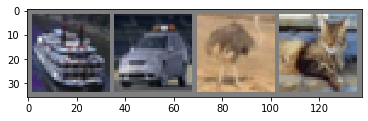

In [ ]:
def imshow(img):    #이미지를 출력해주는 함수.
  img = img/2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)))

dataiter = iter(trainloader)            #loader를 사용해서 반복자를 dataiter에 저장한다.
images, labels = dataiter.next()        #다음 것을 읽어와서 (batch단위로), trainloader를 사용하므로 4개씩 랜덤하게 가져온다. 

imshow(torchvision.utils.make_grid(images))   #이미지 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(4))) #정답 출력

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)                 #인풋 채널 : 3, 아웃풋 채널 : 6, 커널 사이즈 : 5
    self.pool = nn.MaxPool2d(2, 2)                  #MaxPool2d 가로 세로를 반으로 줄인다.
    self.conv2 = nn.Conv2d(6, 16, 5)                #인풋 채널 : 6, 아웃풋 채널 : 16, 커널 사이즈 : 5
    self.fc1 = nn.Linear(16 * 5 * 5, 120)           #인풋 (벡터)사이즈 : 16 * 5 * 5, 아웃풋 (벡터)사이즈 : 120
    self.fc2 = nn.Linear(120, 84)                   #인풋 (벡터)사이즈 : 120, 아웃풋 (벡터)사이즈 : 84
    self.fc3 = nn.Linear(84, 10)                    #인풋 (벡터)사이즈 : 84, 아웃풋 (벡터)사이즈 : 10

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))            #conv1을 해주고 relu통과 후 maxpool2d를 한다.
                                                    #결과 크기 : (32-5)/1 + 1 = 28 => 이것이 conv1과 relu통과 이후 크기이고,
                                                    #여기에 /2를 해준 14가 self.pool을 통과 후 크기이다.
                                                    #따라서 14 * 14 *6이다.
    x = self.pool(F.relu(self.conv2(x)))            #conv2를 해주고 relu통과 후 maxpool2d를 한다.
                                                    #결과 크기 : (14-5)/1 + 1 = 10
                                                    #여기에 /2를 해준 5가 self.pool을 통과 후 크기이다.
                                                    #따라서 5 * 5 * 16이다.
    x = x.view(-1, 16 * 5 * 5)                      #텐서를 벡터로 변환해준다.
    x = F.relu(self.fc1(x))                         #Fully Connect에 16 * 5 * 5의 벡터를 입력으로 주고 120의 크기인 벡터가 아웃풋으로 나온다. 그리고 렐루를 통과시킨다.
    x = F.relu(self.fc2(x))                         #Fully Connect에 120의 벡터를 입력으로 84의 크기인 벡터가 아웃풋으로 나온다. 그리고 렐루를 통과시킨다.
    x = self.fc3(x)                                 #Fully Connect에 84의 벡터를 입력으로 10의 크기인 벡터가 아웃풋으로 나온다.
    return x                                        #10의 크기인 벡터가 리턴된다.
  
net = Net()                                         #인스턴스 생성

criterion = nn.CrossEntropyLoss()                   #손실함수는 크로스엔트로피를 사용한다.
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)   #Stochastic Gradient Descent이하 SGD를 옵티마이저로 사용

for epoch in range(2):                              #2번의 에포크를 실행한다.
  running_loss = 0.0                                #loss값 초기화
  for i, data in enumerate(trainloader, 0):         #훈련집합 반복
    inputs, labels = data                           #data에서 텐서랑 라벨 분리
    optimizer.zero_grad()                           #버퍼를 0으로 초기화

    outputs = net(inputs)                           #output에 인풋을 넣는다.
    loss = criterion(outputs, labels)               #손실함수를 돌려서 loss를 계산한다.

    loss.backward()                                 #역연산을 진행한다.
    optimizer.step()                                #가중치를 갱신한다.

    running_loss += loss.item()                     #tensor 안에 있는 값을 스칼라 값을 꺼내어 출력의 총합을 내준다.
    if i % 1000 == 999:                             #1000번 마다 끝 3자리가 999이면 출력을 해주고 running_loss를 0으로 초기화 해준다.
      print('[%d, %5d] loss: %.3f' %(epoch + 1, i+1, running_loss/1000))    #1000개의 평균으로 에포크, 횟수, loss를 출력한다.
      running_loss = 0.0
print('Finished Training')

[1,  1000] loss: 2.290
[1,  2000] loss: 2.124
[1,  3000] loss: 1.914
[1,  4000] loss: 1.796
[1,  5000] loss: 1.706
[1,  6000] loss: 1.648
[1,  7000] loss: 1.602
[1,  8000] loss: 1.595
[1,  9000] loss: 1.566
[1, 10000] loss: 1.490
[1, 11000] loss: 1.487
[1, 12000] loss: 1.490
[2,  1000] loss: 1.413
[2,  2000] loss: 1.425
[2,  3000] loss: 1.411
[2,  4000] loss: 1.412
[2,  5000] loss: 1.404
[2,  6000] loss: 1.383
[2,  7000] loss: 1.375
[2,  8000] loss: 1.372
[2,  9000] loss: 1.347
[2, 10000] loss: 1.333
[2, 11000] loss: 1.329
[2, 12000] loss: 1.335
Finished Training


GroundTruth:   cat  ship  ship plane


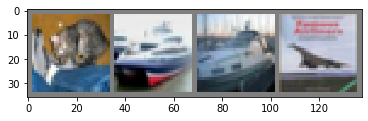

In [ ]:
dataiter = iter(testloader)                                                       #testloader를 사용해서 반복자 생성
images, labels = dataiter.next()                                                  #dataiter를 사용해서 이미지랑 라벨 분리해서 저장.

imshow(torchvision.utils.make_grid(images))                                       #이미지 출력
print('GroundTruth:',' '.join('%5s' % classes[labels[j]] for j in range(4)))      #정답 출력

In [ ]:
outputs = net(images)                                                           #입력 이미지를 output에 저장
_, predicted = torch.max(outputs, 1)                                            #아웃풋에서 값이 제일 큰 인덱스를 predicted에 담는다.
print('Predicted:',' '.join('%5s' % classes[predicted[j]] for j in range(4)))   #값이 제일 큰 classes(예측 결과값)을 출력한다.

Predicted:   cat   car  ship plane


In [ ]:
correct = 0                                                                                 
total = 0
with torch.no_grad():                                                                       #역연산을 사용하지 않는다.
  for data in testloader:                                                                    #testset을 이용해서 만든 testloader를 반복한다.
    images, labels = data                                                                   #데이터에서 이미지 라벨 분리
    outputs = net(images)                                                                   #output에 image를 사용해서 연산을 한다.
    _, predicted = torch.max(outputs.data, 1)                                               #가장 큰 값을 가진 classes의 인덱스를 predicted에 저장한다.
    total += labels.size(0)                                                                 #총 갯수를 total에 더한다.
    correct += (predicted == labels).sum().item()                                           #예측에서 labels와 맞는 것의 갯수를 correct에 누적하여 더한다.

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct/total))

Accuracy of the network on the 10000 test images: 53 %


In [ ]:
class_correct = list(0. for i in range(10))                                                 #클래스 별로 맞은 갯수
class_total = list(0. for i in range(10))                                                   #클래스 별로 있는 총 갯수
with torch.no_grad():                                                                       #역연산을 사용하지 않는다.
  for data in testloader:                                                                   #testloader를 반복한다.
    images, labels = data                                                                   #data에서 이미지랑 라벨을 분리한다.
    outputs = net(images)                                                                   #output에 image를 사용해서 연산을 한다.
    _, predicted = torch.max(outputs, 1)                                                    #가장 큰 값을 가진 classes의 인덱스를 predicted에 저장한다.
    c = (predicted == labels).squeeze()
    for i in range(4):                                                                      #배치 사이즈인 4개를 본다.
      label = labels[i]                                                                     #정답 값의 인덱스를 label에 저장한다.
      class_correct[label] += c[i].item()                                                   #class_correct에 맞았으면 1을 더하고, 틀렸으면 0을 더한다(c[i].item()에 저장되어있다.)
      class_total[label] += 1                                                               #해당하는 클래스의 값을 1증가시킨다.

for i in range(10):                                                                         #총 클래스 크기를 돌면서
  print('Accuracy of %5s : %2d %%' %(classes[i], 100 * class_correct[i]/class_total[i]))    #각 클래스의 종류(plane, car ...)를 문자열과 정확도(맞춘 갯수/총 갯수)를 출력해준다.

Accuracy of plane : 47 %
Accuracy of   car : 71 %
Accuracy of  bird : 31 %
Accuracy of   cat : 31 %
Accuracy of  deer : 56 %
Accuracy of   dog : 45 %
Accuracy of  frog : 61 %
Accuracy of horse : 71 %
Accuracy of  ship : 70 %
Accuracy of truck : 48 %


In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 32, 3)                #인풋 채널 : 3, 아웃풋 채널 : 32, 커널 사이즈 : 3
    self.conv2 = nn.Conv2d(32, 32, 3)               #인풋 채널 : 32, 아웃풋 채널 : 32, 커널 사이즈 : 3
    self.pool = nn.MaxPool2d(2, 2)                  #MaxPool2d 가로 세로를 반으로 줄인다.
    self.fc = nn.Linear(5*5*32, 10)                    #인풋 (벡터)사이즈 : 10, 아웃풋 (벡터)사이즈 : 10

  def forward(self, x):
    x = self.conv1(x)
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv2(self.conv2(x))))
    x = x.view(-1, 5*5*32)
    x = self.fc(x)
    return x

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

trainset = datasets.CIFAR10(root='./data', train = True, download = True, transform = transform)          #CIFAR10에 대한 훈련 데이터셋 다운로드
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 4, shuffle = True, num_workers = 2)      #다운 받은 trainset을 이용해서 loader를 만든다. 이때 배치 사이즈는 4, 랜덤 적용, num_workers는 멀티쓰레딩을 사용해서 한 번에 몇개를 멀티 쓰레딩 할지 입력해 줍니다.

testset = datasets.CIFAR10(root='./data', train = False, download = True, transform = transform)          #CIFAR10에 대한 테스트 데이터셋 다운로드
testloader = torch.utils.data.DataLoader(testset, batch_size = 4, shuffle = False, num_workers = 2)       #다운 받은 testset을 이용해서 loader를 만든다. 이때 배치 사이즈는 4, 랜덤 미적용, num_workers는 2로 한다.

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')                #분류 classes는 다음과 같이 정한다.

dataiter = iter(trainloader)            #loader를 사용해서 반복자를 dataiter에 저장한다.
images, labels = dataiter.next()        #다음 것을 읽어와서 (batch단위로), trainloader를 사용하므로 4개씩 랜덤하게 가져온다. 

net = Net()

criterion = nn.CrossEntropyLoss()                   #손실함수는 크로스엔트로피를 사용한다.
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)   #Stochastic Gradient Descent이하 SGD를 옵티마이저로 사용

for epoch in range(2):                              #2번의 에포크를 실행한다.
  running_loss = 0.0                                #loss값 초기화
  for i, data in enumerate(trainloader, 0):         #훈련집합 반복
    inputs, labels = data                           #data에서 텐서랑 라벨 분리
    optimizer.zero_grad()                           #버퍼를 0으로 초기화

    outputs = net(inputs)                           #output에 인풋을 넣는다.
    loss = criterion(outputs, labels)               #손실함수를 돌려서 loss를 계산한다.

    loss.backward()                                 #역연산을 진행한다.
    optimizer.step()                                #가중치를 갱신한다.

    running_loss += loss.item()                     #tensor 안에 있는 값을 스칼라 값을 꺼내어 출력의 총합을 내준다.
    if i % 1000 == 999:                             #1000번 마다 끝 3자리가 999이면 출력을 해주고 running_loss를 0으로 초기화 해준다.
      print('[%d, %5d] loss: %.3f' %(epoch + 1, i+1, running_loss/1000))    #1000개의 평균으로 에포크, 횟수, loss를 출력한다.
      running_loss = 0.0
print('Finished Training')

Files already downloaded and verified
Files already downloaded and verified
[1,  1000] loss: 2.108
[1,  2000] loss: 1.828
[1,  3000] loss: 1.636
[1,  4000] loss: 1.517
[1,  5000] loss: 1.502
[1,  6000] loss: 1.425
[1,  7000] loss: 1.393
[1,  8000] loss: 1.335
[1,  9000] loss: 1.331
[1, 10000] loss: 1.276
[1, 11000] loss: 1.283
[1, 12000] loss: 1.238
[2,  1000] loss: 1.226
[2,  2000] loss: 1.176
[2,  3000] loss: 1.187
[2,  4000] loss: 1.191
[2,  5000] loss: 1.203
[2,  6000] loss: 1.167
[2,  7000] loss: 1.183
[2,  8000] loss: 1.172
[2,  9000] loss: 1.193
[2, 10000] loss: 1.157
[2, 11000] loss: 1.147
[2, 12000] loss: 1.167
Finished Training


In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)                 #인풋 채널 : 3, 아웃풋 채널 : 6, 커널 사이즈 : 5
    self.pool = nn.MaxPool2d(2, 2)                  #MaxPool2d 가로 세로를 반으로 줄인다.
    self.conv2 = nn.Conv2d(6, 16, 5)                #인풋 채널 : 6, 아웃풋 채널 : 16, 커널 사이즈 : 5
    self.fc1 = nn.Linear(16 * 5 * 5, 120)           #인풋 (벡터)사이즈 : 16 * 5 * 5, 아웃풋 (벡터)사이즈 : 120
    self.fc2 = nn.Linear(120, 84)                   #인풋 (벡터)사이즈 : 120, 아웃풋 (벡터)사이즈 : 84
    self.fc3 = nn.Linear(84, 10)                    #인풋 (벡터)사이즈 : 84, 아웃풋 (벡터)사이즈 : 10

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))  #conv1을 해주고 relu통과 후 maxpool2d를 한다.
                                                    #결과 크기 : (32-5)/1 + 1 = 28 => 이것이 conv1과 relu통과 이후 크기이고,
                                                    #여기에 /2를 해준 14가 self.pool을 통과 후 크기이다.
                                                    #따라서 14 * 14 *6이다.
    x = self.pool(F.relu(self.conv2(x)))  #conv2를 해주고 relu통과 후 maxpool2d를 한다.
                                                    #결과 크기 : (14-5)/1 + 1 = 10
                                                    #여기에 /2를 해준 5가 self.pool을 통과 후 크기이다.
                                                    #따라서 5 * 5 * 16이다.
    x = x.view(-1, 16 * 5 * 5)                      #텐서를 벡터로 변환해준다.
    x = F.relu(self.fc1(x))                         #Fully Connect에 16 * 5 * 5의 벡터를 입력으로 주고 120의 크기인 벡터가 아웃풋으로 나온다. 그리고 렐루를 통과시킨다.
    x = F.relu(self.fc2(x))                         #Fully Connect에 120의 벡터를 입력으로 84의 크기인 벡터가 아웃풋으로 나온다. 그리고 렐루를 통과시킨다.
    x = self.fc3(x)                                 #Fully Connect에 84의 벡터를 입력으로 10의 크기인 벡터가 아웃풋으로 나온다.
    return x                                        #10의 크기인 벡터가 리턴된다.


transform = transforms.Compose([transforms.ColorJitter(hue=.05, saturation=.05),
      transforms.RandomHorizontalFlip(),
      transforms.RandomRotation(20),
      transforms.ToTensor(),
      transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

trainset = datasets.CIFAR10(root='./data', train = True, download = True, transform = transform)          #CIFAR10에 대한 훈련 데이터셋 다운로드
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 4, shuffle = True, num_workers = 2)      #다운 받은 trainset을 이용해서 loader를 만든다. 이때 배치 사이즈는 4, 랜덤 적용, num_workers는 멀티쓰레딩을 사용해서 한 번에 몇개를 멀티 쓰레딩 할지 입력해 줍니다.

testset = datasets.CIFAR10(root='./data', train = False, download = True, transform = transform)          #CIFAR10에 대한 테스트 데이터셋 다운로드
testloader = torch.utils.data.DataLoader(testset, batch_size = 4, shuffle = False, num_workers = 2)       #다운 받은 testset을 이용해서 loader를 만든다. 이때 배치 사이즈는 4, 랜덤 미적용, num_workers는 2로 한다.

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')                #분류 classes는 다음과 같이 정한다.

dataiter = iter(trainloader)            #loader를 사용해서 반복자를 dataiter에 저장한다.
images, labels = dataiter.next()        #다음 것을 읽어와서 (batch단위로), trainloader를 사용하므로 4개씩 랜덤하게 가져온다. 

net = Net()

criterion = nn.CrossEntropyLoss()                   #손실함수는 크로스엔트로피를 사용한다.
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)   #Stochastic Gradient Descent이하 SGD를 옵티마이저로 사용

for epoch in range(2):                              #2번의 에포크를 실행한다.
  running_loss = 0.0                                #loss값 초기화
  for i, data in enumerate(trainloader, 0):         #훈련집합 반복
    inputs, labels = data                           #data에서 텐서랑 라벨 분리
    optimizer.zero_grad()                           #버퍼를 0으로 초기화

    outputs = net(inputs)                           #output에 인풋을 넣는다.
    loss = criterion(outputs, labels)               #손실함수를 돌려서 loss를 계산한다.

    loss.backward()                                 #역연산을 진행한다.
    optimizer.step()                                #가중치를 갱신한다.

    running_loss += loss.item()                     #tensor 안에 있는 값을 스칼라 값을 꺼내어 출력의 총합을 내준다.
    if i % 1000 == 999:                             #1000번 마다 끝 3자리가 999이면 출력을 해주고 running_loss를 0으로 초기화 해준다.
      print('[%d, %5d] loss: %.3f' %(epoch + 1, i+1, running_loss/1000))    #1000개의 평균으로 에포크, 횟수, loss를 출력한다.
      running_loss = 0.0
print('Finished Training')

Files already downloaded and verified
Files already downloaded and verified
[1,  1000] loss: 2.300
[1,  2000] loss: 2.177
[1,  3000] loss: 1.975
[1,  4000] loss: 1.881
[1,  5000] loss: 1.781
[1,  6000] loss: 1.718
[1,  7000] loss: 1.711
[1,  8000] loss: 1.646
[1,  9000] loss: 1.609
[1, 10000] loss: 1.592
[1, 11000] loss: 1.533
[1, 12000] loss: 1.542
[2,  1000] loss: 1.497
[2,  2000] loss: 1.496
[2,  3000] loss: 1.477
[2,  4000] loss: 1.467
[2,  5000] loss: 1.467
[2,  6000] loss: 1.438
[2,  7000] loss: 1.387
[2,  8000] loss: 1.391
[2,  9000] loss: 1.365
[2, 10000] loss: 1.409
[2, 11000] loss: 1.415
[2, 12000] loss: 1.359
Finished Training


In [ ]:
correct = 0                                                                                 
total = 0
with torch.no_grad():                                                                       #역연산을 사용하지 않는다.
  for data in testloader:                                                                    #testset을 이용해서 만든 testloader를 반복한다.
    images, labels = data                                                                   #데이터에서 이미지 라벨 분리
    outputs = net(images)                                                                   #output에 image를 사용해서 연산을 한다.
    _, predicted = torch.max(outputs.data, 1)                                               #가장 큰 값을 가진 classes의 인덱스를 predicted에 저장한다.
    total += labels.size(0)                                                                 #총 갯수를 total에 더한다.
    correct += (predicted == labels).sum().item()                                           #예측에서 labels와 맞는 것의 갯수를 correct에 누적하여 더한다.

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct/total))

Accuracy of the network on the 10000 test images: 51 %


In [ ]:
class_correct = list(0. for i in range(10))                                                 #클래스 별로 맞은 갯수
class_total = list(0. for i in range(10))                                                   #클래스 별로 있는 총 갯수
with torch.no_grad():                                                                       #역연산을 사용하지 않는다.
  for data in testloader:                                                                   #testloader를 반복한다.
    images, labels = data                                                                   #data에서 이미지랑 라벨을 분리한다.
    outputs = net(images)                                                                   #output에 image를 사용해서 연산을 한다.
    _, predicted = torch.max(outputs, 1)                                                    #가장 큰 값을 가진 classes의 인덱스를 predicted에 저장한다.
    c = (predicted == labels).squeeze()
    for i in range(4):                                                                      #배치 사이즈인 4개를 본다.
      label = labels[i]                                                                     #정답 값의 인덱스를 label에 저장한다.
      class_correct[label] += c[i].item()                                                   #class_correct에 맞았으면 1을 더하고, 틀렸으면 0을 더한다(c[i].item()에 저장되어있다.)
      class_total[label] += 1                                                               #해당하는 클래스의 값을 1증가시킨다.

for i in range(10):                                                                         #총 클래스 크기를 돌면서
  print('Accuracy of %5s : %2d %%' %(classes[i], 100 * class_correct[i]/class_total[i]))    #각 클래스의 종류(plane, car ...)를 문자열과 정확도(맞춘 갯수/총 갯수)를 출력해준다.

Accuracy of plane : 39 %
Accuracy of   car : 70 %
Accuracy of  bird : 41 %
Accuracy of   cat : 21 %
Accuracy of  deer : 42 %
Accuracy of   dog : 41 %
Accuracy of  frog : 71 %
Accuracy of horse : 51 %
Accuracy of  ship : 78 %
Accuracy of truck : 52 %


In [ ]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()
 
x = np.array([0.4,2.0,0.001,0.32])
 
y = softmax(x)
print(y)
 
print(np.sum(y))

[0.13250053 0.65627943 0.08890663 0.12231341]
1.0


In [ ]:
y = [0.001, 0.9, 0.001, 0.098]
t = [0, 0, 0, 1]

def mean_squared_error(y,t):
  return  np.sum((y-t)**2) / len(y)

def cross_entropy_error(y,t):
  delta = 1e-7
  return -np.sum(np.log(y+delta))

def loghood(y, idx):
  return np.log2(y[idx]) * -1

print(mean_squared_error(np.array(y), np.array(t)))

print(cross_entropy_error(np.array(y),np.array(t)))

print(loghood(y, 3))      #이렇게 한 이유는 one hot encoding으로
                          #3번만 1이기 때문이다.

0.4059015
16.24345775241425
3.3510744405468786
